# 实验结果与模型评价

In [1]:
# 导入需要使用的包
import os
import mxnet as mx
from mxnet import image
import gluoncv
from glauoncv.data.transforms.presets.segmentation import test_transform
from gluoncv.utils.viz import get_color_pallete,plot_image
from gluoncv import model_zoo, data, utils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

# 忽略警告
import warnings; warnings.filterwarnings(action='once') 
warnings.filterwarnings("ignore")

d:\python\lib\site-packages\gluoncv\__init__.py:40: UserWarning: Both `mxnet==1.7.0` and `torch==1.9.1+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [2]:
# 设定使用GPU或者CUP进行计算，没有安装GPU版本的MXNet请使用CPU
ctx = mx.cpu()

In [3]:
# 下载模型，这里使用的是在Cityscapes数据集上预训练的PSPnet模型
model1 = model_zoo.get_model('fcn_resnet101_ade',ctx=ctx,pretrained=True)
model2 = model_zoo.get_model('fcn_resnet50_ade',ctx=ctx,pretrained=True)
model3 = model_zoo.get_model('deeplab_resnest269_ade',ctx=ctx,pretrained=True)
model4 = model_zoo.get_model('psp_resnet101_ade',ctx=ctx,pretrained=True)

self.crop_size 480


In [4]:
# 评价方法的函数定义
class Evaluator(object):
    def __init__(self, num_class):
        self.num_class = num_class
        self.confusion_matrix = np.zeros((self.num_class,)*2)
        self.no_zero_num_class = 0
        self.new_confusion_matrix = np.zeros((self.num_class,)*2)

    def Pixel_Accuracy(self):
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return Acc

    def Pixel_Accuracy_Class(self):
        Acc = np.diag(self.new_confusion_matrix) / self.new_confusion_matrix.sum(axis=1)
        Acc = np.nanmean(Acc)
        return Acc

    def Mean_Intersection_over_Union(self):
        MIoU = np.diag(self.new_confusion_matrix) / (
                    np.sum(self.new_confusion_matrix, axis=1) + np.sum(self.new_confusion_matrix, axis=0) -
                    np.diag(self.new_confusion_matrix))
        MIoU = np.nanmean(MIoU)
        return MIoU

    def Frequency_Weighted_Intersection_over_Union(self):
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))

        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)
        self.renew()

    def renew(self):
        index = []
        diagEle = []
        for i in range(self.num_class):
            if self.confusion_matrix[i][i] != 0:
                index.append(i)
                self.no_zero_num_class += 1
        confusion_matrix2 = []
        for i in index:
            a = []
            for j in index:
                a.append(self.confusion_matrix[i][j])
            confusion_matrix2.append(a)
        confusion_matrix2 = np.array(confusion_matrix2)
        self.new_confusion_matrix = confusion_matrix2
    
    def reset(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

In [5]:
# 对单张图片进行可视化

def getMask(path, trainingModel, saveName):
    img_path = path
    img = image.imread(img_path)
    img = test_transform(img,ctx=ctx)
    model = trainingModel
    output = model.predict(img)
    predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
    mask = get_color_pallete(predict, 'ade20k')
    mask.save(saveName)
    return mask

path = r'ADE_val_00000001.jpg'
models = [model1, model2, model3 ,model4]
savePicNames = ['preFCN101.png', 'preFCN50.png', 'preDeeplab.png', 'prePsp101.png']


print('开始执行')
for i in range(4):
    getMask(path, models[i], savePicNames[i])

print('执行结束')


开始执行
执行结束


['ADE_val_00000001.jpg', 'preFCN101.png', 'preFCN50.png', 'preDeeplab.png', 'prePsp101.png']


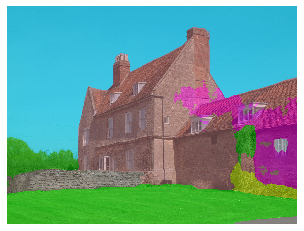

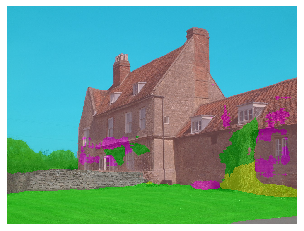

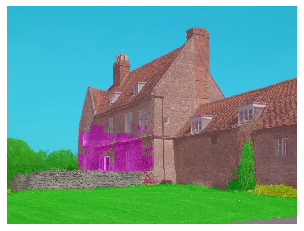

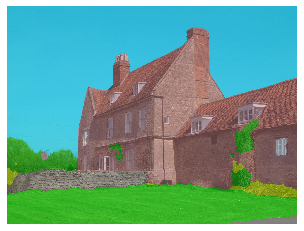

In [6]:
img_paths = [path] + savePicNames
imgs = []
for p in img_paths:    
    imgs.append(mpimg.imread(p))
print(img_paths)

plt.imshow(imgs[0])
plt.imshow(imgs[1],alpha=0.5)
plt.axis('off')
plt.savefig("001.png",dpi=150,bbox_inches='tight')
plt.show()


plt.imshow(imgs[0])
plt.imshow(imgs[2],alpha=0.5)
plt.axis('off')
plt.savefig("002.png",dpi=150,bbox_inches='tight')
plt.show()


plt.imshow(imgs[0])
plt.imshow(imgs[3],alpha=0.5)
plt.axis('off')
plt.savefig("003.png",dpi=150,bbox_inches='tight')
plt.show()

plt.imshow(imgs[0])
plt.imshow(imgs[4],alpha=0.5)
plt.axis('off')
plt.savefig("004.png",dpi=150,bbox_inches='tight')
plt.show()


In [7]:
Eva = Evaluator(151)

def resultOfImg(imgName1, imgName2):
    img2 = image.imread(imgName1)
    img3 = image.imread(imgName2)
    print(img2.shape, img3.shape)
    img2 = img2.asnumpy()
    img3 = img3.asnumpy()
    Eva.add_batch(img2,img3)
    print('PA = {}'.format(Eva.Pixel_Accuracy()))
    print('MPA = {}'.format(Eva.Pixel_Accuracy_Class()))
    print('MIoU = {}'.format(Eva.Mean_Intersection_over_Union()))
    print('FWIoU = {}'.format(Eva.Frequency_Weighted_Intersection_over_Union()))
    Eva.reset()

In [8]:
labelName = 'label.png'
for i in range(4):
    print(savePicNames[i])
    resultOfImg(savePicNames[i],labelName)
    print('-' * 20)

preFCN101.png
(960, 1280, 3) (960, 1280, 3)
PA = 0.9084485124710964
MPA = 0.8295646355651948
MIoU = 0.7749562477050629
FWIoU = 0.8537066362885251
--------------------
preFCN50.png
(960, 1280, 3) (960, 1280, 3)
PA = 0.9239860051213143
MPA = 0.924627213344332
MIoU = 0.8819952176927733
FWIoU = 0.8869483278747149
--------------------
preDeeplab.png
(960, 1280, 3) (960, 1280, 3)
PA = 0.9353591302986406
MPA = 0.9731537429428889
MIoU = 0.9279392875194628
FWIoU = 0.9010378616461805
--------------------
prePsp101.png
(960, 1280, 3) (960, 1280, 3)
PA = 0.9560883293325497
MPA = 0.9670178341934713
MIoU = 0.9196970799339009
FWIoU = 0.9423824495485792
--------------------
